<a href="https://colab.research.google.com/github/julienvos/Stock-analysis/blob/main/Algo_trading_ML_Version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock analysis

Notebook to predict x % amount of increase of the closing price in y days ahead of time

# Import packages

In [ ]:
!pip install yfinance
#!pip install alpha_vantage
!pip install -U scikit-learn

In [ ]:
!pip install dash-renderer
!pip install dash-html-components
!pip install dash-core-components

!pip install jupyter-dash

In [ ]:
import yfinance as yf
#from alpha_vantage.timeseries import TimeSeries
#from alpha_vantage.techindicators import TechIndicators
import datetime
import xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
from jupyter_dash import JupyterDash
import plotly.express as px
import plotly.graph_objects as go

# The Functions to fetch the data and to calculate the technical indicators

## Yahoo stock data

In [ ]:
def data_yahoo(tickers, period= "5y"):
  data = yf.download(  # or pdr.get_data_yahoo(...
          # tickers list or string as well
          tickers = tickers,

          # use "period" instead of start/end
          # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
          # (optional, default is '1mo')
          period = period,

          # fetch data by interval (including intraday if period < 60 days)
          # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
          # (optional, default is '1d')
          interval = "1d",

          # group by ticker (to access via data['SPY'])
          # (optional, default is 'column')
          group_by = 'ticker',

          # adjust all OHLC automatically
          # (optional, default is False)
          auto_adjust = True,

          # download pre/post regular market hours data
          # (optional, default is False)
          prepost = True,

          # use threads for mass downloading? (True/False/Integer)
          # (optional, default is True)
          threads = True,

          # proxy URL scheme use use when downloading?
          # (optional, default is None)
          proxy = None
      )
  return data

### RSI function

In [ ]:
def get_RSI(close_price, window_length=14):

  # Get the % difference in price from previous step (or the diff())
  delta = close_price.pct_change()

  # Get rid of the first row, which is NaN since it did not have a previous 
  # row to calculate the differences
  delta = delta.iloc[1:]

  # Make the positive gains (up) and negative gains (down) Series
  up, down = delta.copy(), delta.copy()
  up[up < 0] = 0
  down[down > 0] = 0

  # Calculate the EWMA
  roll_up1 = up.ewm(span=window_length).mean()
  smooth_roll_up1 = roll_up1.shift(1) * (window_length - 1) + roll_up1 #added to smooth the result
  roll_down1 = down.abs().ewm(span=window_length).mean()
  smooth_roll_down1 = roll_down1.shift(1) * (window_length - 1) + roll_down1 # added to smooth the result

  # Calculate the RSI based on EWMA
  RS1 = smooth_roll_up1 / smooth_roll_down1
  RSI1 = 100.0 - (100.0 / (1.0 + RS1))


  # Calculate the SMA
  roll_up2 = up.rolling(window_length).mean()
  smooth_roll_up2 = roll_up2.shift(1) * (window_length - 1) + roll_up2 #added to smooth the result
  roll_down2 = down.abs().rolling(window_length).mean()
  smooth_roll_down2 = roll_down2.shift(1) * (window_length - 1) + roll_down2 #added to smooth the result

  # Calculate the RSI based on SMA
  RS2 = smooth_roll_up2 / smooth_roll_down2
  RSI2 = 100.0 - (100.0 / (1.0 + RS2))

  return pd.Series(RSI1, name='RSI_EMA')


### MACD function

In [ ]:
def get_MACD(close_price, short_window=12, long_window=26):
  short_ema = 0.15 * close_price + 0.85 * close_price.ewm(span=short_window).mean().shift(1)
  long_ema = 0.075 * close_price + 0.925 * close_price.ewm(span=long_window).mean().shift(1)

  MACD = short_ema - long_ema

  return pd.Series(MACD, name='MACD')

## Technical indicator functions

### Volatility

In [ ]:
def get_volatility(stock_close, period=75):


  daily_pct_change = stock_close.pct_change()
  vol = daily_pct_change.rolling(period).std() * np.sqrt(period)

  return pd.Series(vol.values, name='volatility', dtype='float', index=stock_close.index).fillna(np.median(vol.dropna())) #fill the nan's with median value

###log returns

In [ ]:
def avg_log_returns(close_price, avg_period=[10]):

  """
  returns log returns
  """
  daily_log_returns_shift = pd.DataFrame(np.log(close_price / close_price.shift(1)))

  log_return = pd.DataFrame(index=close_price.index)

  for x in avg_period:
    log_return["log_return_{}_days".format(x)] = daily_log_returns_shift.rolling(x).sum()

  return log_return.fillna(0)

###Ratio close price

In [ ]:
def ratio_avg_close_price(close_price, past_days=[10]):

  ratio = pd.DataFrame(index=close_price.index)
  for x in past_days:
    ratio['ratio_close_price_{}_days'.format(x)] = close_price / close_price.rolling(x).mean()
  return ratio.fillna(1) # fill the first rows with 1 as a ratio

###Target Data

In [ ]:
def create_target_data(close_price, period=10, percent=5):

  """
  Calculates the moments in time where the stock goes  x % up or down after y days in the future

  periods: These are the y days in the future

  percents: These are the %'s up or down after period y

  """

  #close price x days ago
  future_close_price = close_price.shift(period * -1)

  #Did the close price went ..  % up in the past x days?
  percentage = percent/100 + 1

  #df with booleans
  target = future_close_price >= (percentage * close_price) # target is raw since it has a lot of sequences of ones

  #ones and zeros
  target = target.fillna(0) * 1 #fillna to fill the Nan's

  #signal
  # target = target.diff() # mention only the moments when the price STARTS to go up or down after y days

  return pd.Series(data=target.values, name='target', dtype='int', index=close_price.index)



```
#   # Loop over percentages and look forward periods

  if periods == None:
    periods = [5,10,20,30,60]
 
  if percents == None:
    percents = [3,5,10,15,20]
 
  assert type(periods) == list and type(percents) == list, "Please define a list type for periods and/or percents"
 
  booleans = pd.DataFrame(index=close_price.index)
 
  for period in periods:
    for percent in percents:
```



# Output of the functions

## yahoo finance

### Full version of the function

In [ ]:
def total_stock(stock_names, period='1y', target_period=10, target_percent=5):

  assert type(stock_names) == list, "stock_names should be a list"
  
  ordered_df = pd.DataFrame() #empty dataframe
  data = data_yahoo(stock_names, period=period)

  for stock in stock_names:

    if len(stock_names) > 1:
      stock_data = data[stock].copy() # data from 1 stock
    else:
      stock_data = data.copy()

    #label of the stock
    label = pd.Series(index=stock_data.index, name='stock_name', dtype='object').fillna(stock)

    #close price
    stock_close = stock_data['Close']

    #RSI
    RSI = get_RSI(stock_close, window_length=14)

    #MACD
    MACD = get_MACD(stock_close, short_window=12, long_window=26)

    #ratio close prices
    ratio_close_price = ratio_avg_close_price(stock_close, past_days=[30])

    #log_returns
    log_returns = avg_log_returns(stock_close, avg_period=[30, 60, 80])

    #volatility
    volatility = get_volatility(stock_close, period=75)

    #target data
    target_data = create_target_data(stock_close, period=target_period, percent=target_percent)

    full_df = pd.concat([label, stock_data[['Close', 'Volume']], RSI, log_returns, MACD, volatility, target_data], axis=1) #concat all together # ratio_close_price removed
    ordered_df = ordered_df.append(full_df)


  return ordered_df.dropna()

In [ ]:
df = total_stock(['AAPL', 'TSLA'], period="5y")

# Plots

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(external_stylesheets=external_stylesheets)

percentages = [5,10,15,20]
periods = [5,10,15,20,30,60]
years = ['1d','5d','1mo','3mo','6mo','1y','2y','5y','10y','max']

technical_indicators = ['RSI_EMA', 'MACD']

other_graphs = ['ratio_close_price_5_days',
                'ratio_close_price_10_days',    
                'ratio_close_price_20_days',
                'log_return_10_days',
                'log_return_30_days', 
                'log_return_60_days',
                'volatility']

app.layout = html.Div([
                       
                        html.Div([
                                  html.H5('Select the stock', style={'color': 'white'}),

                                  html.Label(children=[
                                                        dcc.Input(id='text_stock', type='text', value='AAPL'),
                                                        html.Button(id='submit_stock', n_clicks=0, children= 'Show', style={'color':'white'})]),
                                                       
                                  
                                  html.Label(dcc.Dropdown(
                                                           id='year_dropdown',
                                                           options=
                                                           [{'label':year, 'value':year} for year in years],
                                                           value="1y",
                                                           multi=False),
                                             
                                                      style={"width" : '60%'}),
                                  
                                  html.Br(),

                                  html.Label(children=[html.Font("Percentage up", style={'color':'white'}),
                                                       dcc.Slider(id='percent_slider',
                                                          min=min(percentages),
                                                          max=(max(percentages)),
                                                          step=None,
                                                          marks={percent : {'label': str(percent) + '%', 'style':{'fontSize': 14}} for percent in percentages},
                                                          dots=True,
                                                          value=5,
                                                          tooltip={'placement':'top'}
                                                                  )
                                                        ],
                                             style={
                                                 'width':'25%'
                                                  }
                                             ),
                                  
                                  html.Br(),

                                          html.Label(children=[html.Font("Days in future", style={'color':'white'}),
                                          dcc.Slider(id='period_slider',
                                          min=min(periods),
                                          max=max(periods),
                                          step=None,
                                          marks={period : {'label': str(period) + ' days', 'style':{'fontSize': 14}} for period in periods},
                                          dots=True,
                                          value=5,
                                          tooltip={'placement':'top'}
                                                  )
                                        ],
                              style={
                                  'width':'50%'
                                  }
                              ),
                                  ]),
                       

                        html.Div(
                        dcc.Graph(id='stock_prices'),
                        # style={
                        #     'float': 'right',
                        #     'width':'70%',
                        #     'margin': '0 1.5%'
                        # }
                        ),
                       
                       #the tech indicator graph
                       html.Br(),

                       html.Label(children=[
                                            html.Font("Technical Indicator", style={'color':'white'}),
                                            dcc.Dropdown(id='indicator_dropdown',
                                                         options=[{'label': "MACD", 'value':"MACD"},
                                                                  {'label': "RSI", 'value':"RSI_EMA"}],
                                                         value="MACD",
                                                          multi=False,
                                                          style={"width" : '60%'})]
                           ),

                       html.Br(),


                       html.Div(dcc.Graph(id='tech_indicator')),
                                
                      #other graphs   
                      html.Br(),      
                      html.Label(children=[
                                            html.Font("Other graphs", style={'color':'white'}),
                                            dcc.Dropdown(id='dropdown_other_graphs',
                                                         options=[{'label': x, 'value': x} for x in other_graphs],
                                                         value=other_graphs[0],
                                                          multi=False,
                                                          style={"width" : '60%'})]
                                ),

                      html.Br(),

                      html.Div(dcc.Graph(id='other_graphs'))

])

@app.callback(
    Output(component_id='stock_prices', component_property='figure'),
    Input(component_id='submit_stock', component_property='n_clicks'),
    Input(component_id='percent_slider', component_property='value'),
    Input(component_id='period_slider', component_property='value'),
    Input(component_id='year_dropdown', component_property='value'),
    State(component_id='text_stock', component_property='value'))

def update_graph(n_clicks, percent, period, year, stock):

  df = total_stock(stock_names=stock.split(" "), period=year, target_percent=percent, target_period=period) 
  #stock.split(" ") means split every stock symbol (based on space) and make a list of the stock symbols

  fig = px.line(data_frame=df,
                x=df.index,
                y='Close',
                line_group='stock_name',
                hover_name='stock_name',
                title='Stock Closing prices',
                color='stock_name',
                labels={'stock_name': 'Stock', 'x': 'Date'}
                )
  
  fig.add_trace(go.Scatter(x=df.loc[df['target'] == 1].index,
                           y=df['Close'].loc[df['target'] == 1],
                           mode='markers',
                           name=str(percent) +  '% up in ' + str(period) + ' days',
                           marker_color='green',
                           marker_symbol='triangle-up',
                           marker_size=15

                           ))

  #fig.update_layout(transition_duration=500)

  return fig


#RSI and MACD indicator  

@app.callback(
    Output(component_id='tech_indicator', component_property='figure'),
    Input(component_id='submit_stock', component_property='n_clicks'),
    Input(component_id='indicator_dropdown', component_property='value'),
    Input(component_id='year_dropdown', component_property='value'),
    State(component_id='text_stock', component_property='value'))

def update_technical_indicator(n_clicks, indicator,year,stock):

  df = total_stock(stock_names=stock.split(" "), period=year)

  fig = px.line(data_frame=df,
              x=df.index,
              y= indicator,
              line_group='stock_name',
              hover_name='stock_name',
              title= indicator,
              color='stock_name',
              labels={'stock_name': 'Stock', 'x': 'Date'})

  # fig.update_layout(transition_duration=700)

  return fig

#other graphs

@app.callback(
    Output(component_id='other_graphs', component_property='figure'),
    Input(component_id='submit_stock', component_property='n_clicks'),
    Input(component_id='dropdown_other_graphs', component_property='value'),
    Input(component_id='year_dropdown', component_property='value'),
    State(component_id='text_stock', component_property='value'))

def update_other_graphs(n_clicks, column,year,stock):

  df = total_stock(stock_names=stock.split(" "), period=year)

  fig = px.line(data_frame=df,
              x=df.index,
              y= column,
              line_group='stock_name',
              hover_name='stock_name',
              title= column,
              color='stock_name',
              labels={'stock_name': 'Stock', 'x': 'Date'})

  # fig.update_layout(transition_duration=700)

  return fig


if __name__ == '__main__':
  app.run_server(mode='inline')

<IPython.core.display.Javascript object>

# The model

##Import modules related to ML

In [ ]:
# !pip install category_encoders

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectFromModel

# from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV, StratifiedKFold

# from xgboost import plot_importance

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from bs4 import BeautifulSoup
import requests


# import category_encoders as ce

## Webscraping to get a list of stock symbols

### yahoo website

In [ ]:
yahoo_url = 'https://finance.yahoo.com/u/yahoo-finance/watchlists/semiconductor-stocks?guccounter=1&guce_referrer=aHR0cHM6Ly9kdWNrZHVja2dvLmNvbS8&guce_referrer_sig=AQAAAH6LL5jzXZFexJPwM7KEeX7q0OfoSOTqDP55q3zlP9SJ4O0v31RsQ_CI9r6iJEvfYUJldiRjZHUWpjN8FxtsRihrEHpN5gFP8K5WEObBIsPmAlNN0lgqNIRRboVxEuVJec45rHoH9kkgnsRCNxYC1DU7zuXS-n0lcr95TVQSg9hr'
yahoo_page = requests.get(yahoo_url)
yahoo_soup = BeautifulSoup(yahoo_page.content)
symbols = yahoo_soup.select('td.data-col0.Ta(start).Pstart(6px).Pend(6px)')

symbol_list = []

for symbol in symbols:
  title = symbol.select('a')[0].string
  symbol_list.append(title)

### tradingview website

In [ ]:
stock_url = "https://www.tradingview.com/markets/stocks-usa/sectorandindustry-industry/semiconductors/"
req = requests.get(stock_url)
stocks = BeautifulSoup(req.content)

stock_list = []

for item in stocks.select("a.tv-screener__symbol"):
  stock_list.append(item.string)

## Split data

In [ ]:
# stocks = ['KLAC', 'TEL', 'IFNNY', 'NXPI', 'HNHPF', 'ADI', 'MU', 'AMD', 'AMAT', 'TSM', 'INTC', 'QCOM', 'MRVL', 'TXN', 'GRMN','NVDA', 'ASML', 'AVGO', 'TER']

stocks = symbol_list

def data_set(stocks):
  # def train_test_set():
  X = total_stock(stocks, period='5y', target_period=15, target_percent=10).drop('stock_name', axis=1)

  X_train = X.loc['2016':'2020']
  y_train = X_train.pop('target')

  # take the last year to test
  X_test = X.loc['2021':]
  y_test = X_test.pop('target')

  # numeric_columns = list(X_train.select_dtypes(np.number))
  # cat_columns = list(X_train.select_dtypes('object'))

  # full_pipe = ColumnTransformer(transformers=[
  #                                           ('num', StandardScaler(), numeric_columns),
  #                                           ('cat', OneHotEncoder(), cat_columns)
  #   ])

  # X_train_prepared = full_pipe.fit_transform(X_train)
  # X_test_prepared = full_pipe.transform(X_test)

  return X_train, y_train, X_test, y_test, X


## Get estimator models

In [ ]:
def get_models():
  models = dict()
  #models['lr'] = LogisticRegression(class_weight='balanced', random_state=42)
  # models['knn'] = KNeighborsClassifier()
  models['forest'] = RandomForestClassifier(class_weight='balanced')
  # models['xgb'] = xgboost.XGBClassifier(scale_pos_weight=10)
  # models['tree'] = DecisionTreeClassifier(class_weight='balanced')
  # models['svc'] = SVC(class_weight='balanced')
  # models['ada'] = AdaBoostClassifier()
  # models['gradient'] = GradientBoostingClassifier()
  return models

In [ ]:
def evaluate_model(model, X,y):
  cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=10, random_state=42)
  scores = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)

  return scores

## Check different models

In [ ]:
X_train, y_train, X_test, y_test = data_set(stocks)
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, X_train_prepared, y_train)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
 
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## Random Forest Classifier

In [ ]:
X_train, y_train, X_test, y_test, X = data_set(stocks)
model = RandomForestClassifier(class_weight='balanced', n_estimators=100)

cv = StratifiedKFold()
score = cross_val_score(model, X_train, y_train, scoring='precision', cv=cv, n_jobs=-1, verbose=1)

# search = HalvingGridSearchCV(model, params, resource='n_estimators', min_resources=50, max_resources=500, scoring='precision', n_jobs=-1, verbose=2, random_state=42, cv=cv)
# params are the standard params

# search_fit = search.fit(X_train, y_train)

In [ ]:
model_features_imp = RandomForestClassifier(class_weight='balanced')
model_features_imp.fit(X_train, y_train)


feature_importance = model_features_imp.feature_importances_
sorted(zip(feature_importance, list(X)), reverse=True)



[(0.20749011470099402, 'volatility'),
 (0.14647617850130537, 'Close'),
 (0.11194443672152056, 'Volume'),
 (0.11174030354128414, 'log_return_60_days'),
 (0.11052021610438663, 'log_return_80_days'),
 (0.1089816430561751, 'MACD'),
 (0.10402956819811787, 'log_return_30_days'),
 (0.09881753917621641, 'RSI_EMA')]

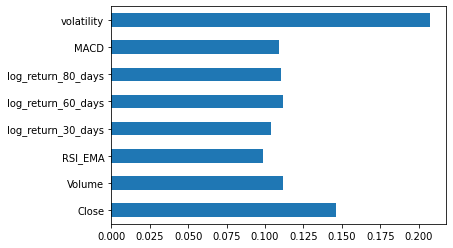

In [ ]:
%matplotlib inline

(pd.Series(feature_importance, index=list(X.drop('target', axis=1)))
    .plot(kind='barh'))